In [1]:
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from scipy import special as sp
from scipy import stats as st
from sklearn.preprocessing import QuantileTransformer as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch_cubic_spline_grids import CubicBSplineGrid2d

import tqdm


In [2]:
df = pd.read_csv('LUXEDumpFiles_FullSim_0p06BX_DetId33_ForStudents.csv')
df_neutrons = df[df[' pdg'].isin([2112])]
# df_photons  = df[df[' pdg'].isin([22])]

KeyboardInterrupt: 

In [ ]:
param_list = [" xx"," yy"," pxx"," pyy"," pzz"," eneg"," time"]
df_N = df_neutrons.loc[:5000000,param_list]
# df_P = df_photons.loc[:,param_list]
torch_tensor = torch.tensor(df_N[param_list].values)

N_data = TensorDataset(torch_tensor,torch.ones(len(torch_tensor)))


In [3]:
df_N = pd.read_csv('Full_Sim_10M.csv')

In [41]:
net_xy =  CubicBSplineGrid2d(resolution=(400,400))
net_et =  CubicBSplineGrid2d(resolution=(400,400))
net_rth = CubicBSplineGrid2d(resolution=(400,400))
net_xy.load_state_dict(torch.load('xy_Corr.py'))
net_et.load_state_dict(torch.load('et_Corr.py'))
net_rth.load_state_dict(torch.load('rth_Corr.py'))
net_xy.eval()
net_et.eval()
net_rth.eval()

CubicBSplineGrid2d()

In [5]:
def plot_correlations(x,y,bins=[400,400],loglog=False,Xlim=None,Ylim=None):
  H,xb,yb = np.histogram2d(x,y,bins=bins,range=[[x.min(), x.max()], [y.min(), y.max()]])
  X , Y = np.meshgrid(xb,yb)
  plt.pcolormesh(X,Y,np.log10(H.T))
  if loglog:
    plt.xscale('log')
    plt.yscale('log')
  if Xlim!=None:
      plt.xlim(Xlim)
  if Ylim!=None:
      plt.ylim(Ylim)
  plt.colorbar()
  plt.show()


In [6]:
def plots(df):
  plot_correlations(df[' xx'],df[' yy'])
  Ebin = 10**np.linspace(np.log10(df[' eneg'].min()), np.log10(df[' eneg'].max()),400)
  Tbin = 10**np.linspace(np.log10(df[' time'].min()), np.log10(df[' time'].max()),400)
  plot_correlations(df[' time'],df[' eneg'] ,bins = [Tbin,Ebin], loglog=True) #
  plot_correlations(df['r'],df['theta'])

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/3865013566.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


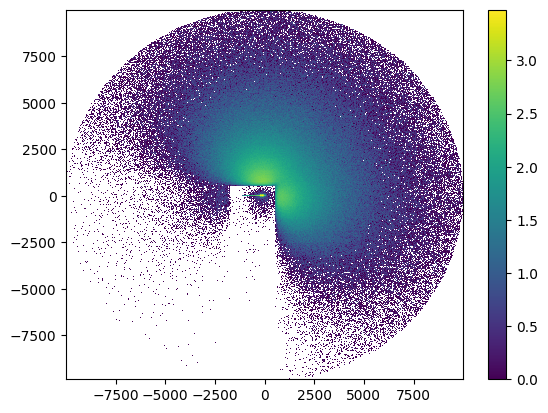

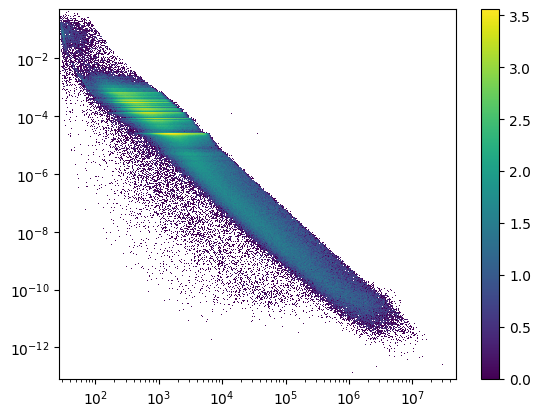

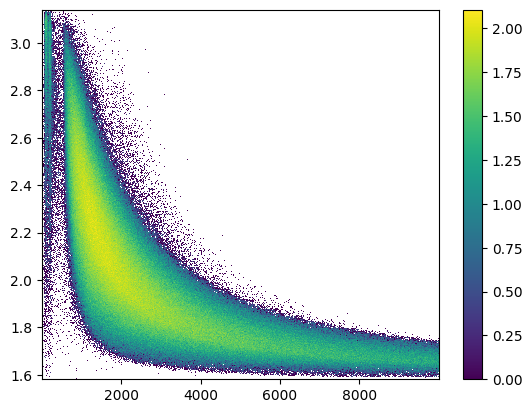

(1154756, 10)


In [7]:
df_N['r'] = np.sqrt(df_N[' xx'].values**2 + df_N[' yy'].values**2)
th_N = np.arccos(df_N[' pzz'].values/np.sqrt(df_N[' pxx'].values**2+df_N[' pyy'].values**2+df_N[' pzz'].values**2))
df_N['theta']=th_N
plots(df_N)
print(df_N.shape)

In [8]:
class ParticleDataset(Dataset):
  def __init__(self, data_path, norm_path):
    super().__init__()
    self.data = pd.read_csv(data_path)
    # self.data = self.data[self.data[' pdg'].isin([2112])]  # 22 - photons , 2112 - neutrons
    self.data = self.data[[" xx"," yy"," pxx"," pyy"," pzz"," eneg"," time"]]
    self.data['r'] = np.sqrt(self.data[' xx'].values**2 + self.data[' yy'].values**2)
    self.data['theta'] = np.arccos(self.data[' pzz'].values/np.sqrt(self.data[' pxx'].values**2+self.data[' pyy'].values**2+self.data[' pzz'].values**2))
    self.norm = pd.read_csv(norm_path, index_col=0)
    self.data[[' eneg',' time']]= np.log(self.data[[' eneg',' time']])
    self.norm['min'][[' eneg',' time']] = np.log(self.norm['min'][[' eneg',' time']])
    self.norm['max'][[' eneg',' time']] = np.log(self.norm['max'][[' eneg',' time']])
    for col in self.norm.index:
        self.data[col] = (self.data[col] - self.norm['min'][col]+ 10**(-5))/(self.norm['max'][col]-self.norm['min'][col]+2*10**(-5))
    
    #QT = qt(output_distribution='normal')
    #self.data = QT.fit_transform(self.data)
    #self.data = np.sqrt(2)*sp.erfinv(2*self.data-1)
    self.data = self.data.astype(np.float32)
    self.data = self.data.values
  def __getitem__(self, item):
    return self.data[item, :]
  def __len__(self):
    return self.data.shape[0]

In [9]:
print(np.max(dataset.data[:,7]))

NameError: name 'dataset' is not defined

In [51]:
dataset = ParticleDataset('Full_Sim_10M.csv', 'Full_Sim_55M_stats.csv')
dataloader = DataLoader(dataset.data[:,:7], batch_size = 256, shuffle = True)


In [160]:
class Generator(nn.Module):
    def __init__(self):
      super().__init__()
      
      N_z = 50
        
      self.main = nn.Sequential(
        nn.Linear(N_z,25),
        nn.LeakyReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,15),
        nn.LeakyReLU(),
        nn.BatchNorm1d(15),
        #nn.Linear(15,9),
        #nn.Dropout(0.3),
        #nn.LeakyReLU(),
        #nn.BatchNorm1d(9),
        nn.Linear(15,7),
        nn.Sigmoid()
      )
    def forward(self, input):
      return self.main(input)
      

In [172]:
class Discriminator(nn.Module):
    def __init__(self):
      super().__init__()
        
      self.main = nn.Sequential(
        nn.Linear(7,25),
        nn.LeakyReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,10),
        nn.LeakyReLU(),
        nn.BatchNorm1d(10),
        nn.Linear(10,1),
        nn.Sigmoid()
      )
    def forward(self, input):
      return self.main(input)
    

In [173]:
mps_device = torch.device('mps')
net_G = Generator().to(mps_device)
net_D = Discriminator().to(mps_device)

print(net_G,net_D)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=25, out_features=15, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=15, out_features=7, bias=True)
    (7): Sigmoid()
  )
) Discriminator(
  (main): Sequential(
    (0): Linear(in_features=7, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=25, out_features=10, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=10, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


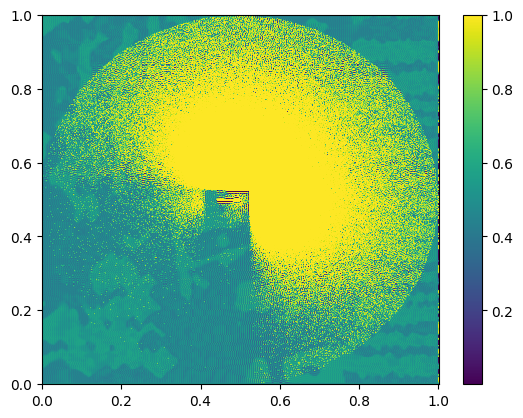

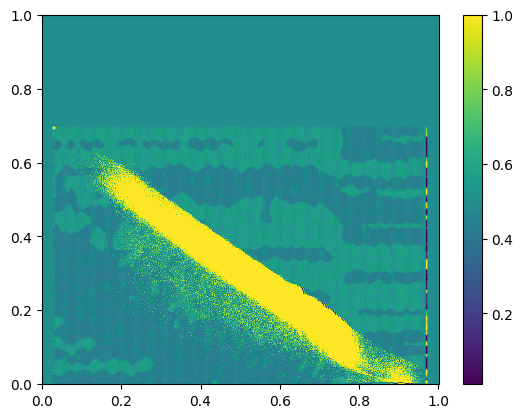

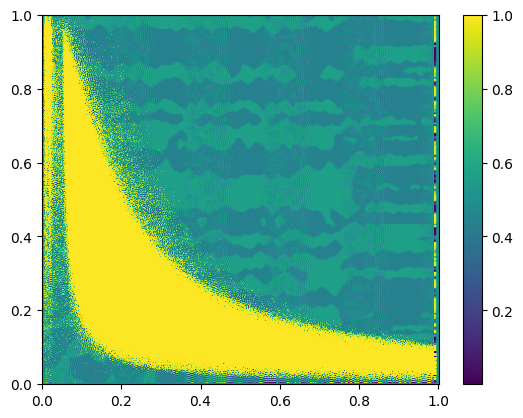

In [174]:
x = torch.linspace(0,1,400)
y = torch.linspace(0,1,400)
net_xy.eval()
net_et.eval()
net_rth.eval()
Rxy  = torch.zeros([400,400])
Ret  = torch.zeros([400,400])
Rrth = torch.zeros([400,400])
for i in range(400):
    X = torch.ones([len(y),1])*x[i]
    Y = y.view(len(y),1)
    Rxy[:,i] = net_xy(torch.cat([X,Y],dim=1))[:,0]
    Ret[:,i] = net_et(torch.cat([X,Y],dim=1))[:,0]
    Rrth[:,i]= net_rth(torch.cat([X,Y],dim=1))[:,0]
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,torch.sigmoid(Rxy).detach().numpy())
plt.colorbar()
plt.figure()
plt.pcolormesh(X,Y,torch.sigmoid(Ret).detach().numpy())
plt.colorbar()
plt.figure()
plt.pcolormesh(X,Y,torch.sigmoid(Rrth).detach().numpy())
plt.colorbar()
plt.show()

In [175]:
class Correlation_Loss(nn.Module):
    def __init__(self,net_xy,net_et,net_rth):
        super().__init__()
        self.net_xy = net_xy.to('cpu')
        self.net_et = net_et.to('cpu')
        self.net_rth = net_rth.to('cpu')
        
    def forward(self, pred):
        loss_xy = self.net_xy(pred[:,[1,0]])
        loss_et = self.net_et(pred[:,[6,5]])
        r = (torch.sqrt(pred[:,0]**2+pred[:,1]**2)).view(len(pred),1)
        theta = (torch.arccos(pred[:,4]/(torch.sqrt(pred[:,2]**2+pred[:,3]**2+pred[:,4]**2)))).view(len(pred),1)
        loss_rth = self.net_rth(torch.cat([theta,r],dim=1))
        sum = -(torch.sigmoid(loss_xy)+torch.sigmoid(loss_et)+torch.sigmoid(loss_rth))
        return sum
    

In [176]:
def weights_init(m):
    if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight.data, 0.0 ,10**(-1))
    elif isinstance(m,nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1,0.02)

In [177]:
loss_func = Correlation_Loss(net_xy,net_et,net_rth)
N_z=50
real_label = 1
fake_label = 0
optimizer_G = optim.Adam(net_G.parameters(), lr = 0.0001, betas= (0.5,0.999))
optimizer_D = optim.Adam(net_D.parameters(), lr = 0.0001, betas= (0.5,0.999))

Starting Training Loop...


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/1424444561.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):


 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/1424444561.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/1424444561.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df[' xx']= fake[:,0]
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/1424444561.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df[' yy']= fake[:,1]
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/3865013566.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


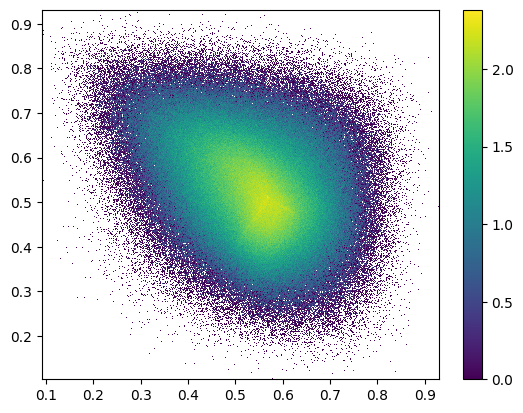

0/100	Loss_D: -0.0015	Loss_G: -0.0093


 batch: 0it [00:00, ?it/s]

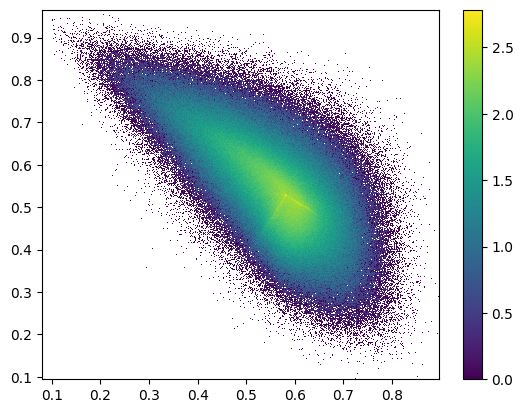

1/100	Loss_D: -0.0028	Loss_G: -0.0096


 batch: 0it [00:00, ?it/s]

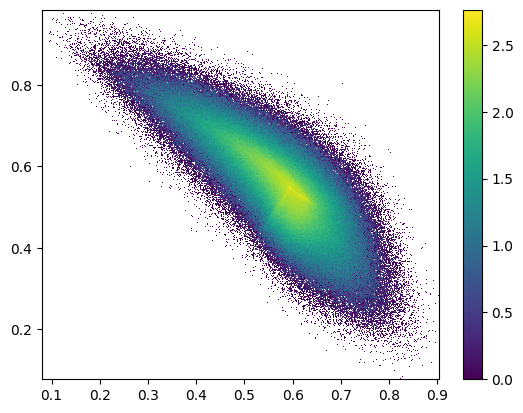

2/100	Loss_D: -0.0032	Loss_G: -0.0099


 batch: 0it [00:00, ?it/s]

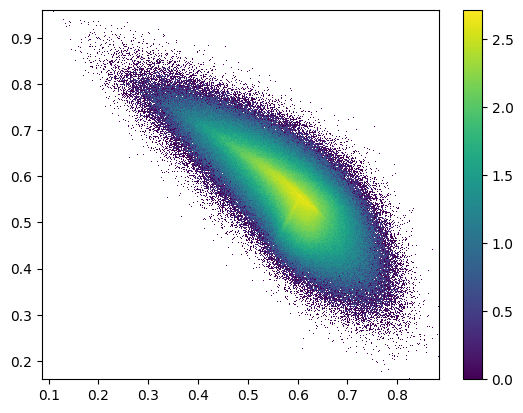

3/100	Loss_D: -0.0034	Loss_G: -0.0099


 batch: 0it [00:00, ?it/s]

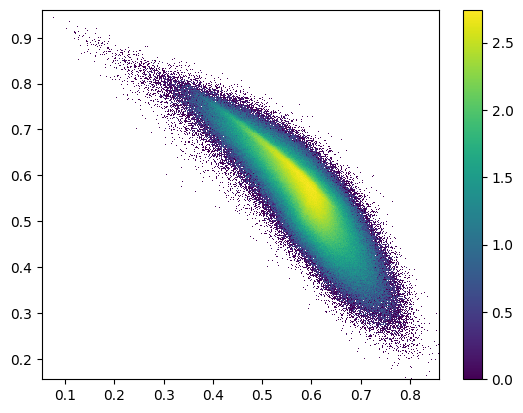

4/100	Loss_D: -0.0034	Loss_G: -0.0099


 batch: 0it [00:00, ?it/s]

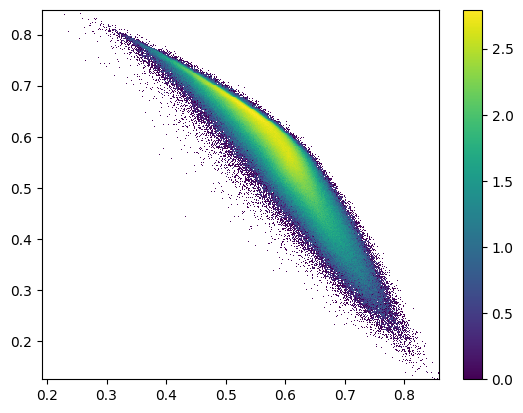

5/100	Loss_D: -0.0033	Loss_G: -0.0100


 batch: 0it [00:00, ?it/s]

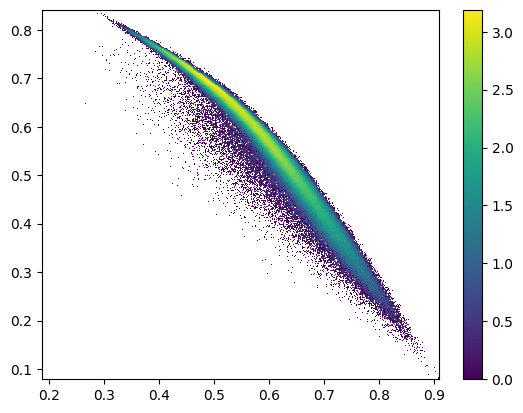

6/100	Loss_D: -0.0031	Loss_G: -0.0105


 batch: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [178]:
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

net_G.apply(weights_init)
net_D.apply(weights_init)
generated_df = df_N[[' xx',' yy']]

print("Starting Training Loop...")

for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):
    net_G.to(mps_device)
    net_G.train()

    avg_error_G, avg_error_D = 0, 0
    avg_Dx, avg_DGz1, avg_DGz2 = 0., 0., 0.

    for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):

        # Update the discriminator network

        ## Train with all-real batch
        net_D.zero_grad()
        b_size = len(data)
        real_data = data.to(mps_device)
        
        output = net_D(real_data)

        err_D_real = -torch.mean(output)
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        noise = torch.randn(b_size, N_z, device=mps_device)
        fake_p = net_G(noise)

        output = net_D(fake_p.detach())
        err_D_fake = torch.mean(output)
        fake_p.to(mps_device)
        err_D = err_D_real + err_D_fake
        err_D.backward()

        # update the discriminator network
        optimizer_D.step()
        
        # Update the Generator network
        net_G.zero_grad()
        output = net_D(fake_p)
        err_G = -torch.mean(output) + torch.mean(loss_func(fake_p.cpu()))
        err_G.backward()
        
        # update the generator network
        optimizer_G.step()
        
        # computing the average losses and discriminator
        avg_error_G += err_G.item()
        avg_error_D += err_D.item()

        iters += 1

    avg_error_G = avg_error_G/len(dataloader.dataset)
    avg_error_D = avg_error_D/len(dataloader.dataset)
    if len(G_losses)>0:
        if avg_error_G<G_losses[-1]:
            torch.save(net_G.state_dict(), 'saved_Gen.pt')
    noise = torch.randn(1154756, N_z, device='cpu')
    net_G.eval()
    net_G.to('cpu')
    fake = net_G(noise).detach().numpy()
    generated_df[' xx']= fake[:,0]
    generated_df[' yy']= fake[:,1]
    plot_correlations(generated_df[' xx'], generated_df[' yy'])
    G_losses.append(avg_error_G)
    D_losses.append(avg_error_D)
    print(f'{epoch}/{num_epochs}\tLoss_D: {avg_error_D:.4f}\tLoss_G: {avg_error_G:.4f}')

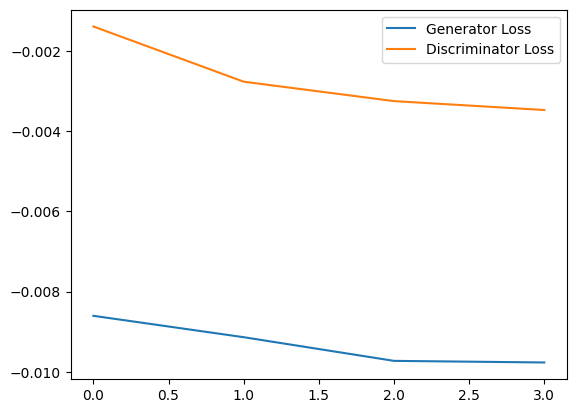

In [168]:
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()

In [180]:
noise = torch.randn(1154756, N_z, device='cpu')
net_G.eval()
net_G.to('cpu')
fake_p = net_G(noise).detach().numpy()

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/3865013566.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


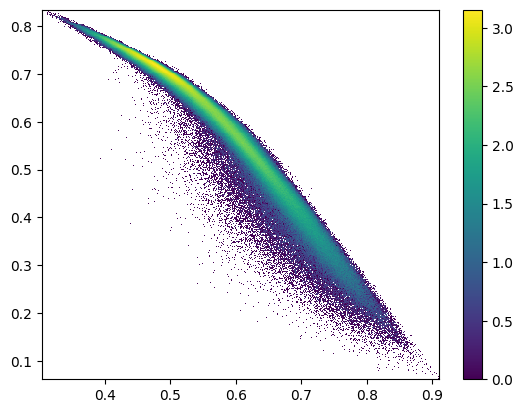

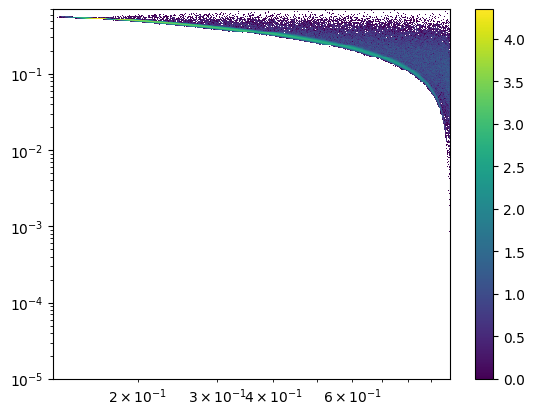

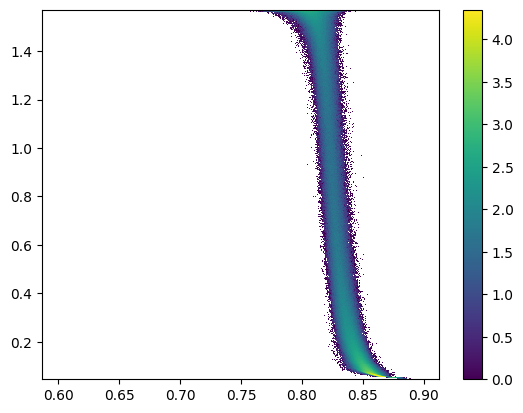

In [181]:
generated_df = df_N.copy()
param_list = [' xx',' yy',' pxx',' pyy',' pzz',' eneg',' time']
for i in range(len(param_list)):
    min = dataset.norm.loc[param_list[i]]['min']
    max =  dataset.norm.loc[param_list[i]]['max']
    generated_df[param_list[i]]= fake_p[:,i]
    # generated_df[param_list[i]]= sp.erf(fake_p[:,i]/np.sqrt(2))
    # generated_df[param_list[i]]= (fake_p[:,i]*(max-min)+np.ones(len(fake_p[:,i]))*(max+min)+10**(-5))/2
generated_df[[' eneg',' time']]=generated_df[[' eneg',' time']]-np.min(generated_df[[' eneg',' time']])+10**(-5)

generated_df['r']=np.sqrt(generated_df[' xx']**2+generated_df[' yy']**2)
th_g = np.arccos(generated_df[' pzz'].values/np.sqrt(generated_df[' pxx'].values**2+generated_df[' pyy'].values**2+generated_df[' pzz'].values**2))
generated_df['theta']=th_g
plots(generated_df)

#plots(df_N)

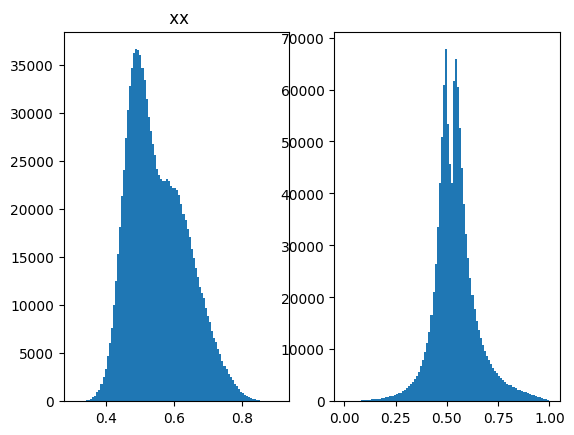

<Figure size 640x480 with 0 Axes>

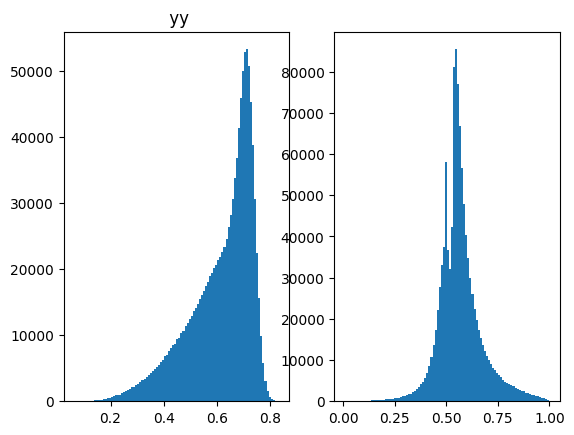

<Figure size 640x480 with 0 Axes>

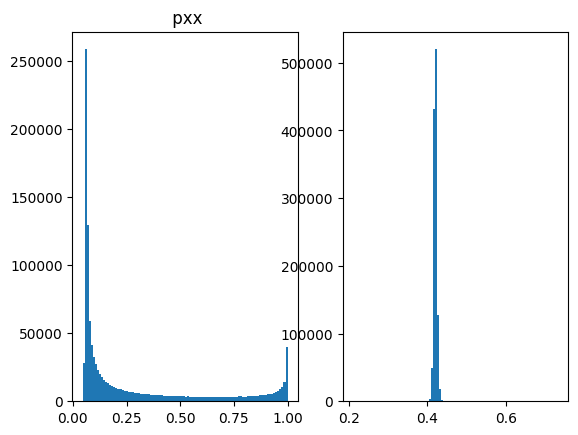

<Figure size 640x480 with 0 Axes>

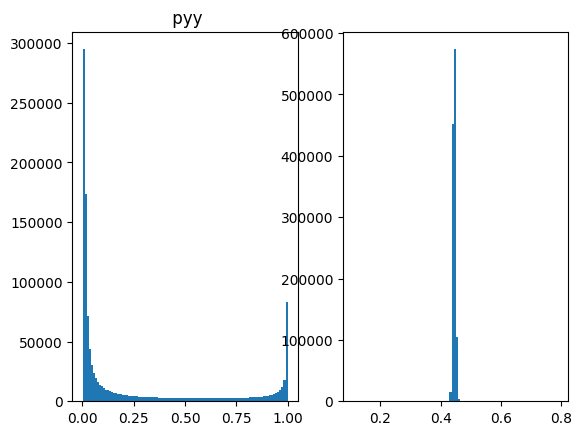

<Figure size 640x480 with 0 Axes>

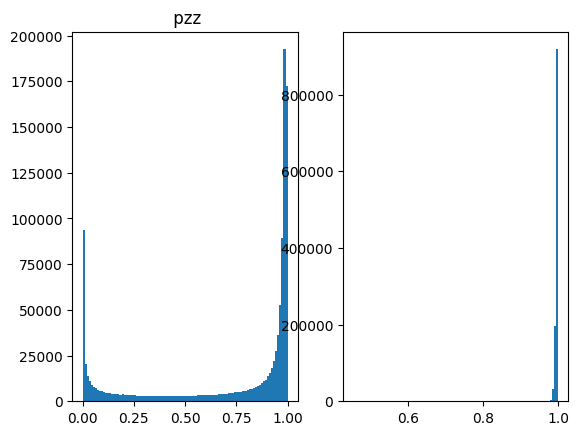

<Figure size 640x480 with 0 Axes>

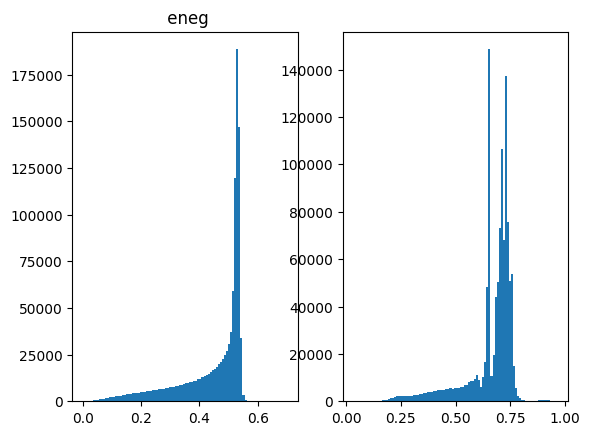

<Figure size 640x480 with 0 Axes>

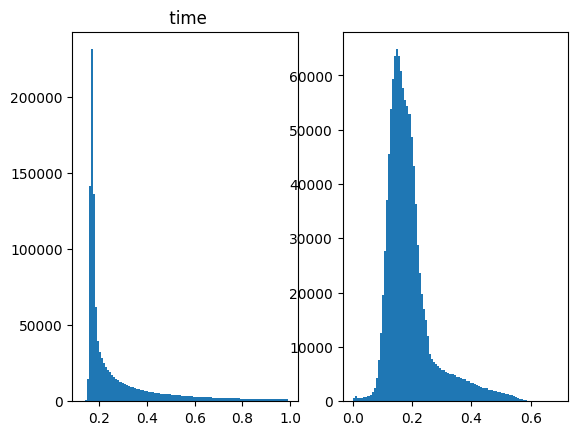

<Figure size 640x480 with 0 Axes>

In [182]:
for i in range(7):
    fig, axs = plt.subplots(1,2,squeeze=False)
    axs[0,0].hist(generated_df[param_list[i]],bins=100)
    axs[0,1].hist(dataset.data[:,i],bins=100)
    axs[0,0].set_title(param_list[i])
    plt.figure()
plt.show()

In [657]:
torch.save(net_G.state_dict(), 'saved_Gen.pt')